In [1]:
#Simulation to demonstrate myopic control on a toy nonlinear dynamical system: inverted pendulum
#This notebook will demonstrate the use of first- and second-order myopic control to make
#a controlled pendulum under gravitational force g and pendulum length L to move as though
#gravity were reversed (i.e., g --> -g)

#Copyright Catniplab, 2017.
#Written by David Hocker

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
from tf_funs import *
import sys

tf.set_random_seed(101)
pi = math.pi
np.random.seed(101)

sess = tf.Session()


In [2]:
def ip_dynamics(X,C,g,L,dt):
    #function for inverted pendulum dynamics
    return dt*np.array([X[1]+C[0],g/L*math.sin(X[0])+C[1]])
def ip_dynamics_tf(X,C,g,L,dt):
    #function for inverted pendulum dynamics, using tensorflow
    return tf.stack([dt*(X[1]+C[0]),dt*(g/L*tf.sin(X[0])+C[1])])

In [12]:
#build the tensorflow graphs
xdim = 2 #state dimension
udim = 2 #control dimension

print('Initializing Tensorflow variables')
X_est = tf.placeholder(shape=(xdim),dtype=tf.float32,name='X_est') #the state estimate
PI_est = tf.placeholder(shape = (xdim,xdim),dtype=tf.float32, name = 'PI_est') #estimated covariance
Y_tp1 = tf.placeholder(shape=(xdim),dtype=tf.float32, name = 'Y_tp1') #the most recent observation
Control = tf.placeholder(shape = udim, dtype=tf.float32, name='Control')

#params for experiment
dt = 1.0e-3 #temporal resolution

#define the noise for the system
sigsstate = (1./dt)*9e-9 #state noise covariance strength
sigsobs = 1.0e-6 #observation noise covariance strength
Q = sigsstate*np.eye(xdim)
Q_tf = tf.constant(Q,dtype=tf.float32, name = 'Q') #state noise covariance
R = sigsobs*np.eye(xdim)
R_tf = tf.constant(R,dtype=tf.float32, name = 'R') #observation noise covariance  
gamma = 1.0e-8 #control regularizaiton strength

#gradients for updating state and observation
print('Building gradient graphs')
g = 9.8 #gravity
gtarg = -9.8 #target gravity
L = 1 #pendulum length
true_model_est = ip_dynamics_tf(X_est,Control,g,L,dt)#state est. gradient, full myopic
true_model_est_null = ip_dynamics_tf(X_est,[0.,0.],g,L,dt)#state est. gradient w/o control
target_model_est = ip_dynamics_tf(X_est,[0.,0.],gtarg,L,dt) #state est. target model

#the non-tensorflow gradient functions
true_nontf = lambda x,c: ip_dynamics(x,c,g,L,dt)
target_nontf = lambda x: ip_dynamics(x,[0.,0.],gtarg,L,dt)

#state estimation and covariance estimation graphs
print('Building state and covariance estimation graphs')
X_plus,PI_plus = EKF(X_est,Y_tp1,PI_est,true_model_est,true_model_est_null,Q_tf,R_tf,xdim,dt)

#graphs for myopic controller
print('Building controller graph')
useMO = 1 #handle for first- or second-order control
if useMO ==1:
    print('using first-order control')
    Cnew = myopicController_meanonly(
        X_est,PI_est,Control,gamma,true_model_est,
        true_model_est_null,target_model_est,xdim,udim)
else:
    print('using second-order control')
    Cnew = myopicController_noBdiff(
        X_est,PI_est,Control,gamma,true_model_est,
        true_model_est_null,target_model_est,xdim,udim)

#covariance prediction update graph
Ak = dynamics_linearized(X_est,true_model_est_null,xdim)
#loss function
loss_tf = loss_full(X_est,PI_est,true_model_est,target_model_est)

print('Done!')

Initializing Tensorflow variables
Building gradient graphs
Building state and covariance estimation graphs
Building controller graph
using first-order control
Done!


In [19]:
#begin specifics of the simulation
T = 5000 #number of time steps
Tcstart = 1 #time steps number at which control begins. allows beta oscillation
ns = 1 #number of samples

#make the numpy version of noise
statenoise = np.random.normal(0,sigsstate**0.5,[xdim,T,ns])
obsnoise = np.random.normal(0,sigsobs**0.5,[xdim,T,ns])
G = dt**(0.5)*np.eye(xdim) #system noise matrix, for covariance prediction

#vectors of interest
x_estvec = np.zeros((xdim,T,ns)) #state estimate
x_ucvec = np.zeros((xdim,T,ns)) #uncontrolled state
xvec = np.zeros((xdim,T,ns)) #actual controlled state
yvec = np.zeros((xdim,T,ns)) #observations related to state
x_targvec = np.zeros((xdim,T,ns)) #target state
PI_estvec = np.zeros((xdim,xdim,T,ns)) #estimated covariance
contall = np.zeros((udim,T,ns)) #control
loss = np.zeros((T,ns)) #loss function for controlled dynamics
loss_nocont = np.zeros((T,ns))#loss function, no control
initvals = np.zeros((xdim,ns))#initial state values

lag = 1 #(number of steps+1) difference between observations and state estimate

#initialize graphs
init = tf.global_variables_initializer()

for m in range(ns):
    #initialize vectors
    #start between 0.1 and 0.2 to be in disease state
    x_init = np.random.uniform(0,math.pi,(2,))
    initvals[:,m] = x_init
    print('simulation #: '+str(m))
    print('initial point: ' + str(x_init)  )
    PI_init = [[1e-4,0.],[0.,1e-4]] #initial covariance
    c_init = [0.,0.]

    x_estvec[:,0,m] = x_init
    xvec[:,0,m] = x_init
    x_ucvec[:,0,m] = x_init
    x_targvec[:,0,m] = x_init   
    PI_estvec[:,:,0,m] = PI_init
    
    #initial loss
    loss[0,m] = np.linalg.norm(
            true_nontf(x_estvec[:,0,m],c_init)-target_nontf(x_estvec[:,0,m]))
    loss_nocont[0,m] = np.linalg.norm(
            true_nontf(x_estvec[:,0,m],[0.,0.])-target_nontf(x_estvec[:,0,m]))

    #go ahead and propagate lag-steps ahead before starting state estimation and such
    for k in range(1,lag):
        #update actual dynamics
        grad_cont = true_nontf(xvec[:,k-1,m],c_init)
        grad_targ = target_nontf(x_targvec[:,k-1,m])
        xvec[:,k,m] = xvec[:,k-1,m] + grad_cont + statenoise[:,k,m]
        x_targvec[:,k,m] = x_targvec[:,k-1,m] + grad_targ + statenoise[:,k,m]
        yvec[:,k,m] = xvec[:,k,m] + obsnoise[:,k,m]
        #uncontrolled dynamics
        grad_cont = true_nontf(x_ucvec[:,k-1,m],c_init)
        x_ucvec[:,k,m] = x_ucvec[:,k-1,m] + grad_cont + statenoise[:,k,m]
        

        #set estimates in beginning lags to initial state
        x_estvec[:,k,m] = x_init
        PI_estvec[:,:,k,m] = PI_init
        
        #calculate loss
        #mean-only loss
        loss[k,m] = np.linalg.norm(
            true_nontf(x_estvec[:,k,m],c_init)-target_nontf(x_estvec[:,k,m]))
        loss_nocont[k,m] = np.linalg.norm(
            true_nontf(x_estvec[:,k,m],[0.,0.])-target_nontf(x_estvec[:,k,m]))
        

    #now propagate with lagged observations
    for k in range(max(1,lag),T): 
        #update actual dynamics
        grad_cont = true_nontf(xvec[:,k-1,m],contall[:,k-1,m])
        grad_targ = target_nontf(x_targvec[:,k-1,m])
        xvec[:,k,m] = xvec[:,k-1,m] + grad_cont + statenoise[:,k,m]
        x_targvec[:,k,m] = x_targvec[:,k-1,m] + grad_targ + statenoise[:,k,m]
        yvec[:,k,m] = xvec[:,k,m] + obsnoise[:,k,m]
        #uncontrolled dynamics
        grad_cont = true_nontf(x_ucvec[:,k-1,m],c_init)
        x_ucvec[:,k,m] = x_ucvec[:,k-1,m] + grad_cont + statenoise[:,k,m]

        #run state estimator to update estimate of state with observation lag
        test = sess.run([X_plus,PI_plus],
                        {X_est:x_estvec[:,k-lag,m], PI_est:PI_estvec[:,:,k-lag,m],
                         Control:contall[:,k-lag,m], Y_tp1:yvec[:,k-lag+1,m]})
        x_estvec[:,k-lag+1,m] = test[0]
        PI_estvec[:,:,k-lag+1,m] = test[1]
        
        #begin predicting k states in the future to calculate control
        x_est_n = x_estvec[:,k-lag+1,m]
        PI_est_n = PI_estvec[:,:,k-lag+1,m]
        #calculate predicted covariance via sampling now
        #ensure symmetric  
        PI_est_n[0,1] = PI_est_n[1,0]     
        if lag > 1:     
            gf = lambda x: grad_threechoice(x[0],x[1],dt,[0.,0.])
            PI_est_n = covariancePredict(x_estvec[:,k-lag+1,m],PI_estvec[:,:,k-lag+1,m],100,lag-1,gf)

        #predicted state mean
        for n in range(1,lag):
            #state prediction step
            grad_cont = true_nontf(x_est_n,contall[:,k-lag+n,m])
            x_est_n = x_est_n + grad_cont

            if sum(np.isnan(grad_cont)) > 0:
                print('gradcont became unstable. quitting simulation')
                quit()
            elif sum(np.isnan(x_est_n)) > 0:
                print('x_est_n became unstable. quitting simulation')
                quit()
            elif sum(sum(np.isnan(PI_est_n))) > 0:
                print('PI became unstable. quitting simulation')
                quit()
            elif sum(np.isnan(contall[:,k-lag+n,m])) > 0:
                print('cont became unstable. quitting simulation')
                quit()

        #calculate control signal
        if k > Tcstart:
            c_k = sess.run(Cnew,{X_est:x_est_n, PI_est:PI_est_n,
                                 Control:contall[:,k-1,m], Y_tp1:yvec[:,k,m]})
            contall[:,k,m] = c_k

        #mean-only loss
        loss[k-lag+1,m] = np.linalg.norm(
            true_nontf(x_estvec[:,k-lag+1,m],
                       contall[:,k-lag+1,m])-target_nontf(x_estvec[:,k-lag+1,m]))
        loss_nocont[k-lag+1,m] = np.linalg.norm(
            true_nontf(x_estvec[:,k-lag+1,m],[0.,0.])-target_nontf(x_estvec[:,k-lag+1,m]))
          
        #full second-order loss via tensorflow. note: sometimes unstable
        #ltest = sess.run(loss_tf,{X_est:x_estvec[:,k-lag+1,m],
        #                                       PI_est:PI_estvec[:,:,k-lag+1,m],
        #                                       Control:contall[:,k-lag+1,m]
        #                                      })
        #loss[:,k-lag+1,m] = ltest      
        #ltest = sess.run(loss_tf,{X_est:x_estvec[:,k-lag+1,m],
        #                                       PI_est:PI_estvec[:,:,k-lag+1,m],
        #                                       Control:np.array([0.,0.])
        #                                      })
        #loss_nocont[:,k-lag+1,m] = ltest

    #set final k-estimated values to previous value
    for k in range(lag-1):
        x_targvec[:,T-lag+1+k,m] = x_targvec[:,T-lag,m]
        x_estvec[:,T-lag+1+k,m] = x_estvec[:,T-lag,m]
        x_ucvec[:,T-lag+1+k,m] = x_ucvec[:,T-lag,m]
        PI_estvec[:,:,T-lag+1+k,m] = PI_estvec[:,:,T-lag,m]
        PI_estvec[:,:,T-lag+1+k,m] = PI_estvec[:,:,T-lag,m]
        #pad final loss points to avoid zeros
        loss[T-lag+1+k,m] = loss[T-lag,m]
        loss_nocont[T-lag+1+k,m] = loss_nocont[T-lag,m]

simulation #: 0
initial point: [ 0.74061918  2.33599109]


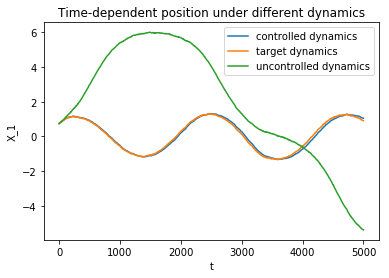

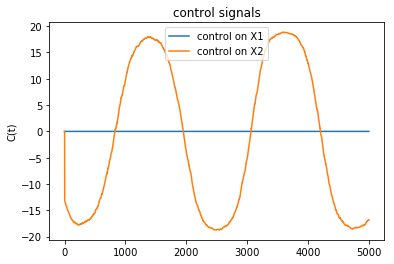

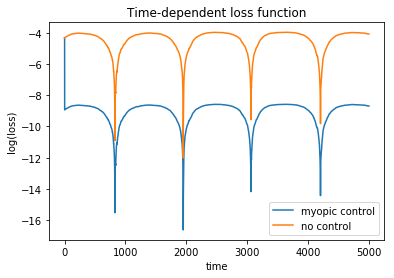

In [21]:
#plotting of some basic results
tind = 0 #sample number to plot

#Trajectories in state space
plt.plot(x_estvec[0,:,tind],label='controlled dynamics')
plt.plot(x_targvec[0,:,tind],label = 'target dynamics')
plt.plot(x_ucvec[0,:,tind],label = 'uncontrolled dynamics')
plt.legend()
plt.xlabel('t')
plt.ylabel('X_1')
plt.title('Time-dependent position under different dynamics')
plt.show()

#Control signals
plt.plot(contall[0,:,tind],label='control on X1')
plt.plot(contall[1,:,tind],label='control on X2')
plt.ylabel('C(t)')
plt.title('control signals')
plt.legend()
plt.show()

#Log of loss function over time
fullloss = plt.plot(np.log(loss[:,tind]),label='myopic control')
nocontloss = plt.plot(np.log(loss_nocont[:,tind]),label='no control')

plt.xlabel('time')
plt.ylabel('log(loss)')
plt.title('Time-dependent loss function')
plt.legend()
plt.show()


